## CIFAR-10 CNN Classification with TensorFlow



Developed a comprehensive CNN image classification system on CIFAR-10 (60,000 32x32 color images across 10 classes: airplane, automobile, bird, cat, deer, dog, frog, horse, ship, truck) using TensorFlow/Keras. Implemented from-scratch CNN alongside transfer learning with MobileNetV2, EfficientNetB0, VGG16, and ResNet50V2, featuring data augmentation, checkpoint-resumable training, and evaluation targeting 75-85%+ test accuracy.

## Importing the libraries

In [1]:
# Import the necessary libraries
import tensorflow as tf
from tensorflow import keras
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt
import random
import numpy as np
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Conv2D, MaxPool2D, Flatten, Dense, BatchNormalization, Dropout, GlobalAveragePooling2D, GlobalMaxPooling2D
from tensorflow.keras import layers
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications import MobileNetV2, EfficientNetB0, VGG16, ResNet50V2

## Dataset loading and Preprocessing

In [2]:
# Load in the dataset
dataset,info = tfds.load("cifar10", with_info=True, as_supervised=True)

train_data_original = dataset["train"]
test_data = dataset["test"]

# Get total train examples
train_size = info.splits["train"].num_examples

# Define split sizes (80% train, 20% validation)
val_size = int(0.2 * train_size)
train_size_final = train_size - val_size

# Shuffle the data before splitting
train_data_original = train_data_original.shuffle(train_size, seed=42)

# Split train data
train_data_raw = train_data_original.take(train_size_final).cache()
val_data_raw = train_data_original.skip(train_size_final).take(val_size).cache()
test_data_raw = test_data.cache()

print(f"Train data size: {len(train_data_raw)}")
print(f"Validation data size: {len(val_data_raw)}")
print(f"Test data size: {len(test_data_raw)}")

class_names = info.features["label"].names
print(f"Class names: {class_names}")

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/2 [00:00<?, ? splits/s]

Generating train examples...: 0 examples [00:00, ? examples/s]

Shuffling /root/tensorflow_datasets/cifar10/incomplete.2EGEIV_3.0.2/cifar10-train.tfrecord*...:   0%|         …

Generating test examples...: 0 examples [00:00, ? examples/s]

Shuffling /root/tensorflow_datasets/cifar10/incomplete.2EGEIV_3.0.2/cifar10-test.tfrecord*...:   0%|          …

Dataset cifar10 downloaded and prepared to /root/tensorflow_datasets/cifar10/3.0.2. Subsequent calls will reuse this data.
Train data size: 40000
Validation data size: 10000
Test data size: 10000
Class names: ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']


In [3]:
def check_image(data):
  """ Inspect the first batch of a tf.data.Dataset for debugging.

    Args:
        data: tf.data.Dataset yielding (images, labels) batches.

    Prints:
        Shape of the image tensor (e.g., (32, 32, 32, 3) for CIFAR-10).
        Corresponding labels tensor.
    """
  for image, label in data.take(1):
    print(f"Image shape: {image.shape}")
    print(f"Label: {label}")

In [4]:
print("Train data:")
check_image(train_data_raw)
print("Validation data:")
check_image(val_data_raw)
print("Test data:")
check_image(test_data_raw)

Train data:
Image shape: (32, 32, 3)
Label: 2
Validation data:
Image shape: (32, 32, 3)
Label: 0
Test data:
Image shape: (32, 32, 3)
Label: 7


In [5]:
# Visualize random image from train,validation and test datasets
def plot_random_image(data, class_names):
  shuffled_data = data.shuffle(50000)

  for image, label in shuffled_data.take(1):
    label_index = label.numpy()
    label = class_names[label_index]
    plt.imshow(image)
    plt.title(label)
    print(f"Image shape: {image.shape}")
    plt.axis(False)
    plt.show()

    return image


Image shape: (32, 32, 3)


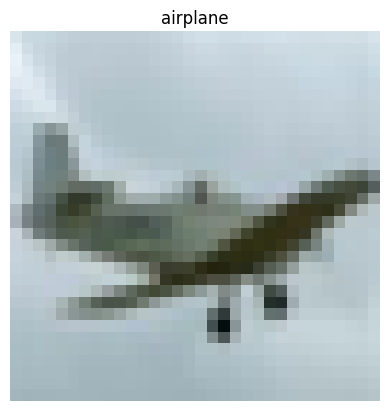

<tf.Tensor: shape=(32, 32, 3), dtype=uint8, numpy=
array([[[216, 229, 234],
        [202, 217, 224],
        [199, 216, 224],
        ...,
        [210, 223, 229],
        [209, 222, 229],
        [214, 227, 234]],

       [[226, 238, 244],
        [207, 221, 228],
        [198, 213, 222],
        ...,
        [203, 217, 225],
        [203, 217, 225],
        [208, 222, 230]],

       [[232, 242, 248],
        [216, 228, 236],
        [202, 216, 225],
        ...,
        [200, 215, 224],
        [199, 214, 223],
        [204, 219, 228]],

       ...,

       [[168, 187, 194],
        [166, 185, 192],
        [167, 186, 193],
        ...,
        [186, 201, 206],
        [187, 202, 207],
        [189, 204, 209]],

       [[166, 185, 193],
        [165, 184, 191],
        [165, 184, 191],
        ...,
        [181, 196, 201],
        [182, 197, 202],
        [185, 200, 205]],

       [[163, 182, 189],
        [160, 179, 186],
        [161, 180, 187],
        ...,
        [177, 192, 197]

In [6]:
# Random image from training data
train_image = plot_random_image(train_data_raw, class_names)
train_image

Image shape: (32, 32, 3)


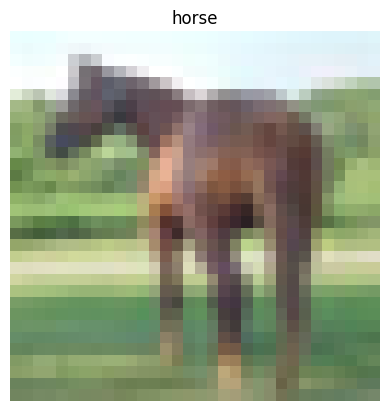

<tf.Tensor: shape=(32, 32, 3), dtype=uint8, numpy=
array([[[235, 255, 255],
        [234, 255, 255],
        [235, 255, 255],
        ...,
        [222, 244, 251],
        [222, 243, 249],
        [223, 245, 250]],

       [[237, 253, 254],
        [235, 251, 252],
        [237, 253, 254],
        ...,
        [221, 240, 246],
        [221, 239, 245],
        [222, 241, 247]],

       [[243, 255, 255],
        [240, 253, 253],
        [241, 253, 254],
        ...,
        [228, 239, 245],
        [225, 240, 247],
        [226, 242, 250]],

       ...,

       [[137, 158, 103],
        [140, 161, 106],
        [146, 166, 112],
        ...,
        [ 90, 121,  77],
        [ 84, 117,  76],
        [ 85, 119,  79]],

       [[106, 131,  92],
        [106, 131,  92],
        [109, 134,  95],
        ...,
        [105, 127,  89],
        [ 95, 121,  90],
        [ 94, 121,  92]],

       [[113, 133,  95],
        [114, 134,  96],
        [118, 138, 100],
        ...,
        [103, 129, 100]

In [7]:
# Random image from test data
test_image = plot_random_image(test_data_raw, class_names)
test_image

Image shape: (32, 32, 3)


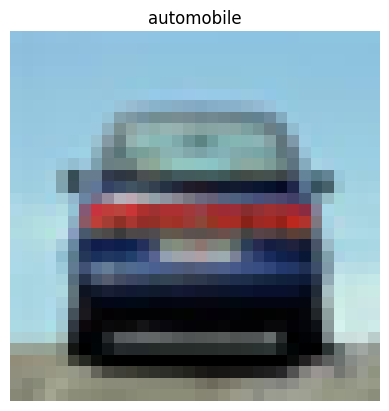

<tf.Tensor: shape=(32, 32, 3), dtype=uint8, numpy=
array([[[143, 193, 224],
        [142, 192, 222],
        [143, 192, 223],
        ...,
        [141, 196, 224],
        [141, 196, 224],
        [141, 196, 224]],

       [[142, 192, 222],
        [141, 190, 220],
        [142, 191, 221],
        ...,
        [141, 195, 223],
        [141, 195, 223],
        [140, 194, 222]],

       [[143, 193, 223],
        [142, 191, 221],
        [143, 192, 222],
        ...,
        [141, 195, 223],
        [141, 195, 223],
        [141, 195, 223]],

       ...,

       [[144, 143, 126],
        [147, 146, 129],
        [148, 148, 131],
        ...,
        [134, 136, 128],
        [152, 155, 143],
        [143, 148, 129]],

       [[142, 143, 126],
        [132, 133, 116],
        [137, 139, 121],
        ...,
        [148, 151, 134],
        [154, 157, 139],
        [151, 154, 135]],

       [[135, 136, 118],
        [130, 131, 113],
        [146, 147, 129],
        ...,
        [150, 153, 133]

In [8]:
# Random image from validation data
val_image = plot_random_image(val_data_raw, class_names)
val_image

In [9]:
# Define a preprocessing function to rescale images
NUM_CLASSES = info.features["label"].num_classes

def preprocess_image(image, label):
  """Normalize images to [0,1] range and one-hot encode labels.

    Args:
        image: Integer tensor of pixel values (e.g., 0-255).
        label: Integer class index (e.g., 0-9 for CIFAR-10).

    Returns:
        Tuple of (normalized_image, one_hot_label).
    """
  image = tf.cast(image, tf.float32)/255.0    # Scale to [0,1]
  label = tf.one_hot(label, depth=NUM_CLASSES) # One-hot with class count
  return image, label

In [10]:
BATCH_SIZE = 32

# Set the seed
tf.random.set_seed(42)

# Process the training data
train_data = train_data_raw.map(preprocess_image, num_parallel_calls=tf.data.AUTOTUNE) \
                                      .shuffle(buffer_size=50000, seed=42) \
                                      .batch(BATCH_SIZE) \
                                      .prefetch(tf.data.AUTOTUNE)

# Process the validation data
val_data = val_data_raw.map(preprocess_image, num_parallel_calls=tf.data.AUTOTUNE) \
                                     .batch(BATCH_SIZE) \
                                     .prefetch(tf.data.AUTOTUNE)
# Process the test data
test_data = test_data_raw.map(preprocess_image, num_parallel_calls=tf.data.AUTOTUNE) \
                                     .batch(BATCH_SIZE) \
                                     .prefetch(tf.data.AUTOTUNE)

print("Preprocessed train data:", train_data)
print("Preprocessed validation data:", val_data)
print("Preprocessed test data:", test_data)

Preprocessed train data: <_PrefetchDataset element_spec=(TensorSpec(shape=(None, 32, 32, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 10), dtype=tf.float32, name=None))>
Preprocessed validation data: <_PrefetchDataset element_spec=(TensorSpec(shape=(None, 32, 32, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 10), dtype=tf.float32, name=None))>
Preprocessed test data: <_PrefetchDataset element_spec=(TensorSpec(shape=(None, 32, 32, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 10), dtype=tf.float32, name=None))>


In [11]:
len(train_data), len(val_data), len(test_data)

(1250, 313, 313)

In [12]:
def min_max(data):
  """ Verify dtype and value range of images in first dataset batch.

    Args:
        data: tf.data.Dataset with (image, label) batches.

    Prints:
        Image dtype (e.g., int32 pre-normalization, float32 post).
        Min/max pixel values (expect 0-255 raw, 0-1 normalized).
    """
  for image, label in data.take(1):
    print(f"dtype: {image.dtype}")
    print(f"min-value: {tf.reduce_min(image)}")
    print(f"max-value: {tf.reduce_max(image)}")

In [13]:
print("Train data:")
min_max(train_data)
print("Validation data:")
min_max(val_data)
print("Test data:")
min_max(test_data)

Train data:
dtype: <dtype: 'float32'>
min-value: 0.0
max-value: 1.0
Validation data:
dtype: <dtype: 'float32'>
min-value: 0.0
max-value: 1.0
Test data:
dtype: <dtype: 'float32'>
min-value: 0.0
max-value: 1.0


## CNN Model Architecture

CNN stands for Convolutional Neural Network, a deep learning architecture specialized for processing grid-like data such as images. It excels in tasks like image classification and object detection by mimicking the human visual cortex through layers that detect features hierarchically.

In [14]:
# Create the model
model = Sequential([
    Conv2D(32, (3,3), activation="relu", input_shape=(32, 32, 3)),
    Conv2D(32, (3,3), activation="relu"),
    MaxPool2D(),  # Reduces spatial dims by 2x
    Conv2D(64, (3,3), activation="relu"),
    Conv2D(64, (3,3), activation="relu"),
    MaxPool2D(),  # Further downsampling
    Flatten(),   # Converts 2D features to 1D
    Dense(128, activation="relu"),
    Dense(10, activation="softmax") # 10 CIFAR-10 classes
])

# Compile the model
model.compile(loss="categorical_crossentropy", # Matches one-hot labels from preprocess_image
              optimizer=Adam(),                # Adaptive learning rate (default lr=0.001)
              metrics=["accuracy"])            # Tracks top-1 accuracy during training


/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [15]:
history = model.fit(train_data,                     # Training tf.data.Dataset (preprocessed CIFAR-10)
                    epochs=30,                      # Full passes through training data
                    steps_per_epoch=len(train_data), # Batches per epoch (dataset length)
                    validation_data=val_data,       # Validation tf.data.Dataset
                    validation_steps=len(val_data)) # Validation batches per epoch

Epoch 1/30
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 14s 6ms/step - accuracy: 0.3633 - loss: 1.7285 - val_accuracy: 0.5764 - val_loss: 1.1586
Epoch 2/30
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.6114 - loss: 1.0902 - val_accuracy: 0.6882 - val_loss: 0.8810
Epoch 3/30
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.6927 - loss: 0.8672 - val_accuracy: 0.7480 - val_loss: 0.7082
Epoch 4/30
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.7431 - loss: 0.7355 - val_accuracy: 0.7582 - val_loss: 0.6981
Epoch 5/30
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 7s 5ms/step - accuracy: 0.7797 - loss: 0.6231 - val_accuracy: 0.8148 - val_loss: 0.5442
Epoch 6/30
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.8143 - loss: 0.5248 - val_accuracy: 0.8288 - val_loss: 0.5088
Epoch 7/30
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 7s 5ms/step - accuracy: 0.8364 - loss: 0.4599 - val_accuracy: 0.8453 - val_loss: 0.4679
Epoch 8/30
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.8606 - loss: 0.3842 -

In [16]:
# Plot validation and training curves seaprately
def plot_loss_curves(history):
  """
  Returns separate loss curves for training and validation metrics.
  """
  loss = history.history["loss"]
  val_loss = history.history["val_loss"]

  accuracy = history.history["accuracy"]
  val_accuracy = history.history["val_accuracy"]

  epochs = range(len(history.history["loss"]))

  # Plot loss
  plt.plot(epochs, loss, label="training_loss")
  plt.plot(epochs, val_loss, label="val_loss")
  plt.title("Loss")
  plt.xlabel("Epochs")
  plt.legend()

  # Plot accuracy
  plt.figure()
  plt.plot(epochs, accuracy, label="training_accuracy")
  plt.plot(epochs, val_accuracy, label="val_accuracy")
  plt.title("Accuracy")
  plt.xlabel("Epochs")
  plt.legend()

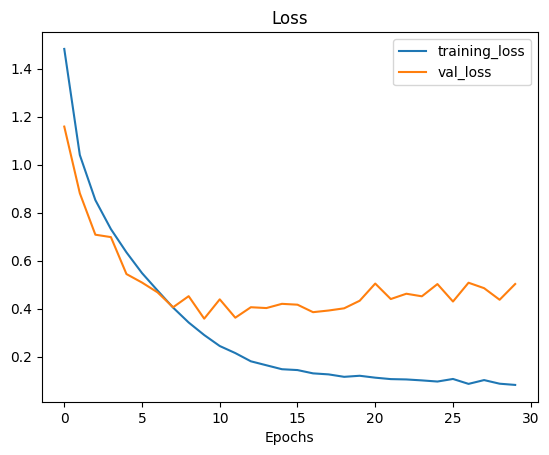

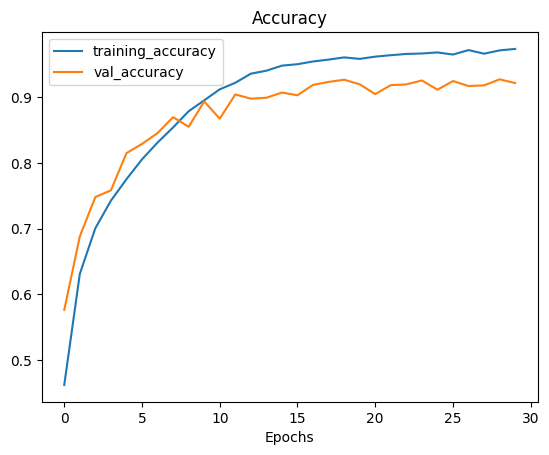

In [17]:
plot_loss_curves(history)

In [18]:
# Evaluate the model
test_loss, test_acc = model.evaluate(test_data)
print(f"Test accuracy: {test_acc:.4f}")


313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.7081 - loss: 2.2711
Test accuracy: 0.6992


### Data Augmentation

Data augmentation artificially expands training datasets in machine learning by creating modified versions of existing data, improving model robustness without collecting new samples.

In [19]:
data_augmentation = Sequential([
    layers.RandomFlip("horizontal"),  # 50% chance horizontal flip
    layers.RandomRotation(0.2),       # ±20% rotation (up to ~11.5°)
    layers.RandomZoom(0.2),           # ±20% zoom in/out
    layers.RandomContrast(0.2)        # ±20% contrast adjustment
])

### Callbacks creation

Callbacks in machine learning, particularly in frameworks like Keras and TensorFlow, are functions or objects that execute automatically at specific points during model training, such as the start or end of an epoch, batch processing, or training completion. They enable monitoring, logging, and dynamic adjustments to optimize the training process without altering the core model code.

In [20]:
# Create callbacks
early_stop = tf.keras.callbacks.EarlyStopping(
    monitor="val_loss",       # Watch validation loss
    patience=5,               # Stop after 5 epochs no improvement
    restore_best_weights=True # Revert to best weights
)

reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(
    monitor="val_loss",       # Watch validation loss
    factor=0.5,               # Halve learning rate
    patience=3,               # After 3 epochs no improvement
    min_lr=1e-5               # Lowest allowed LR
)


In [21]:
# Create the model
model_aug = Sequential([
    data_augmentation,                    # Augmentation layers first
    Conv2D(32, (3,3), padding="same", activation="relu", input_shape=(32,32,3)),
    Conv2D(32, (3,3), padding="same", activation="relu"),
    MaxPool2D((2,2)),
    BatchNormalization(),
    Dropout(0.25),

    Conv2D(64, (3,3), padding="same", activation="relu"),
    Conv2D(64, (3,3), padding="same", activation="relu"),
    MaxPool2D((2,2)),
    BatchNormalization(),
    Dropout(0.25),

    Conv2D(128, (3,3), padding="same", activation="relu"),
    Conv2D(128, (3,3), padding="same", activation="relu"),
    MaxPool2D((2,2)),
    BatchNormalization(),
    Dropout(0.25),

    Conv2D(256, (3,3), padding="same", activation="relu"),
    Conv2D(256, (3,3), padding="same", activation="relu"),
    MaxPool2D((2,2)),
    BatchNormalization(),
    Dropout(0.3),
    GlobalAveragePooling2D(),             # Replaces Flatten, reduces params

    Dense(512, activation="relu"),
    BatchNormalization(),
    Dropout(0.5),
    Dense(10, activation="softmax")
])

# Compile the model
model_aug.compile(
              loss="categorical_crossentropy",
              optimizer=Adam(learning_rate=0.001),
              metrics=["accuracy"])

In [22]:
history_aug = model_aug.fit(
                    train_data,                   # Preprocessed + augmented training data
                    epochs=30,                    # Max epochs (early stopping likely triggers sooner)
                    steps_per_epoch=len(train_data),
                    validation_data=val_data,
                    validation_steps=len(val_data),
                    callbacks=[early_stop, reduce_lr])  # Prevents overfitting, optimizes convergence

Epoch 1/30
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 33s 17ms/step - accuracy: 0.2405 - loss: 2.4079 - val_accuracy: 0.3685 - val_loss: 1.7660 - learning_rate: 0.0010
Epoch 2/30
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 23s 17ms/step - accuracy: 0.3964 - loss: 1.7013 - val_accuracy: 0.4484 - val_loss: 1.6026 - learning_rate: 0.0010
Epoch 3/30
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 24s 18ms/step - accuracy: 0.4596 - loss: 1.5186 - val_accuracy: 0.4610 - val_loss: 1.6361 - learning_rate: 0.0010
Epoch 4/30
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 23s 17ms/step - accuracy: 0.5029 - loss: 1.4040 - val_accuracy: 0.5769 - val_loss: 1.1789 - learning_rate: 0.0010
Epoch 5/30
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 23s 17ms/step - accuracy: 0.5316 - loss: 1.3197 - val_accuracy: 0.5933 - val_loss: 1.1544 - learning_rate: 0.0010
Epoch 6/30
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 40s 17ms/step - accuracy: 0.5588 - loss: 1.2485 - val_accuracy: 0.6277 - val_loss: 1.0596 - learning_rate: 0.0010
Epoch 7/30
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 22s 17ms/step - accura

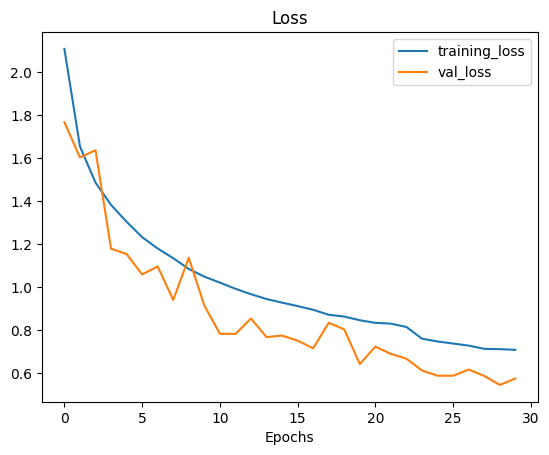

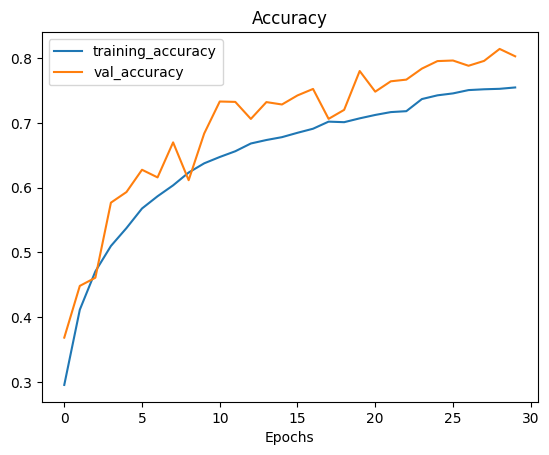

In [23]:
plot_loss_curves(history_aug)

In [24]:
# Evaluate the model
test_loss, test_acc = model_aug.evaluate(test_data)
print(f"Test accuracy: {test_acc:.4f}")

313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.7883 - loss: 0.6124
Test accuracy: 0.7837


### Saving the CNN model

In [25]:
# Save the entire model
model_aug.save("model_aug.h5")

### Testing the CNN model

In [26]:
# Load the saved model
model = tf.keras.models.load_model("model_aug.h5")

# CIFAR-10 class names
class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

# Load and preprocess single image (32x32x3 required)
def predict_image(model,img_path):
  # Load image
  img = image.load_img(img_path, target_size=(32, 32))
  plt.imshow(img)
  plt.title(f"Input: {img_path}")
  plt.axis("off")
  plt.show()

  # Preprocess the image (must match training pipeline)
  img_array = image.img_to_array(img)
  img_array = np.expand_dims(img_array, axis=0) # Add batch dimension: (1,32,32,3)
  img_array = tf.cast(img_array, tf.float32)/255.0

  # Predict
  prediction = model.predict(img_array)
  predicted_class = class_names[np.argmax(prediction)]
  confidence = np.max(prediction) * 100
  print(f"Predicted class: {predicted_class}")
  print(f"Confidence: {confidence:.2f}%")

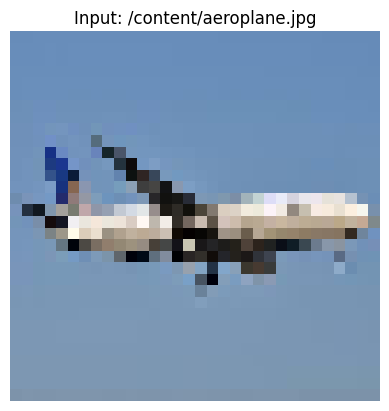

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 486ms/step
Predicted class: airplane
Confidence: 99.97%


In [27]:
predict_image(model,"/content/aeroplane.jpg")

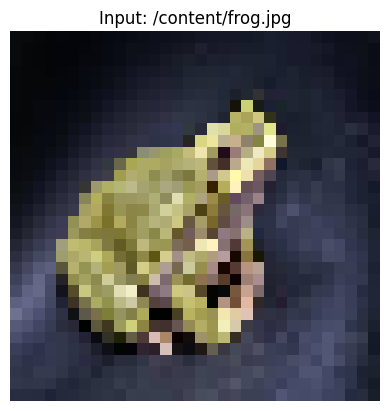

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
Predicted class: frog
Confidence: 100.00%


In [28]:
predict_image(model,"/content/frog.jpg")

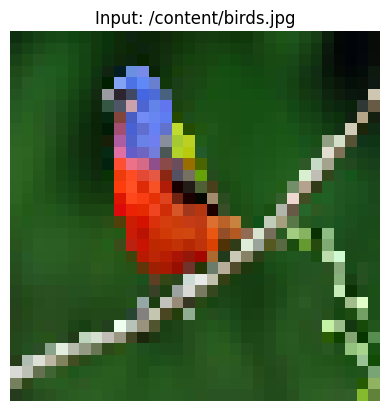

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
Predicted class: bird
Confidence: 98.44%


In [29]:
predict_image(model,"/content/birds.jpg")

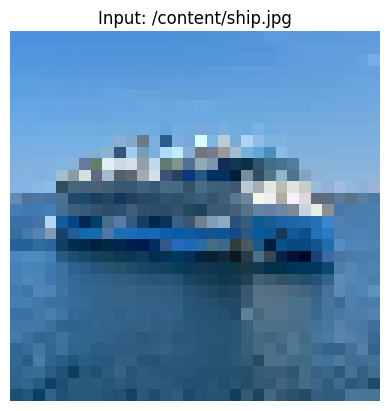

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
Predicted class: ship
Confidence: 99.73%


In [30]:
predict_image(model,"/content/ship.jpg")

## Transfer Learning

Transfer learning reuses parts of a pre-trained machine learning model for a new but related task, leveraging generalized knowledge to improve efficiency. This technique is especially useful in deep learning when data or resources for training from scratch are limited.

### MobileNetV2 Model Architecture

MobileNetV2 is a lightweight convolutional neural network architecture designed for efficient performance on mobile and embedded devices, building on MobileNetV1 with inverted residuals and linear bottlenecks.

In [31]:
# CIFAR-10 classes
class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

# PHASE 1: Build + Freeze Base (Train Head Only)
base_model = MobileNetV2(
    input_shape=(32, 32, 3),
    alpha=1.0,  # Full MobileNetV2
    include_top=False,
    weights='imagenet',  # Pretrained weights
    pooling=None
)

# Freeze base
base_model.trainable = False

# Add your classifier (same as before)
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(512, activation="relu")(x)
x = BatchNormalization()(x)
x = Dropout(0.5)(x)
predictions = Dense(10, activation="softmax")(x)

model_mobilenet = Model(inputs=base_model.input, outputs=predictions)

# Compile Phase 1 (higher LR for head)
model_mobilenet.compile(
    loss="categorical_crossentropy",
    optimizer=Adam(learning_rate=0.001),  # Higher LR
    metrics=["accuracy"]
)

print("Phase 1: Training head only...")
history_mobilenet_phase1 = model_mobilenet.fit(
    train_data, epochs=10,  # Fewer epochs
    validation_data=val_data,
    callbacks=[early_stop, reduce_lr]
)


/tmp/ipython-input-1054990996.py:5: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  base_model = MobileNetV2(


9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Phase 1: Training head only...
Epoch 1/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 39s 18ms/step - accuracy: 0.2375 - loss: 2.3038 - val_accuracy: 0.3467 - val_loss: 1.8069 - learning_rate: 0.0010
Epoch 2/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 11s 8ms/step - accuracy: 0.3108 - loss: 1.9008 - val_accuracy: 0.3599 - val_loss: 1.7779 - learning_rate: 0.0010
Epoch 3/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 11s 8ms/step - accuracy: 0.3247 - loss: 1.8559 - val_accuracy: 0.3583 - val_loss: 1.7478 - learning_rate: 0.0010
Epoch 4/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 11s 8ms/step - accuracy: 0.3228 - loss: 1.8512 - val_accuracy: 0.3706 - val_loss: 1.7354 - learning_rate: 0.0010
Epoch 5/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 11s 8ms/step - accuracy: 0.3299 - loss: 1.8281 - val_accuracy: 0.3746 - val_loss: 1.7286 - learning_rate: 0.0010
Epoch 6/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 11s 8ms/step - accuracy: 0.3402 - loss: 1.8135 - val_accuracy: 0.3813 - val_loss: 1.7106 - learning_ra

In [32]:
# PHASE 2: Fine-tune entire model
base_model.trainable = True  # Unfreeze all layers

# Lower LR for fine-tuning (protect pretrained weights)
model_mobilenet.compile(
    loss="categorical_crossentropy",
    optimizer=Adam(learning_rate=0.0001),  # 10x lower LR
    metrics=["accuracy"]
)

In [33]:
print("Phase 2: Fine-tuning entire model...")
history_mobilenet_phase2 = model_mobilenet.fit(
    train_data, epochs=20,
    validation_data=val_data,
    callbacks=[early_stop, reduce_lr]
)


Phase 2: Fine-tuning entire model...
Epoch 1/20
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 72s 19ms/step - accuracy: 0.2462 - loss: 2.5415 - val_accuracy: 0.2023 - val_loss: 2.1748 - learning_rate: 1.0000e-04
Epoch 2/20
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 20s 15ms/step - accuracy: 0.4514 - loss: 1.6079 - val_accuracy: 0.4908 - val_loss: 1.6320 - learning_rate: 1.0000e-04
Epoch 3/20
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 19s 14ms/step - accuracy: 0.5331 - loss: 1.3502 - val_accuracy: 0.6216 - val_loss: 1.1567 - learning_rate: 1.0000e-04
Epoch 4/20
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 20s 14ms/step - accuracy: 0.6005 - loss: 1.1619 - val_accuracy: 0.7015 - val_loss: 0.8687 - learning_rate: 1.0000e-04
Epoch 5/20
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 19s 14ms/step - accuracy: 0.6479 - loss: 1.0198 - val_accuracy: 0.7450 - val_loss: 0.7381 - learning_rate: 1.0000e-04
Epoch 6/20
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 19s 14ms/step - accuracy: 0.6843 - loss: 0.9155 - val_accuracy: 0.7713 - val_loss: 0.6626 - learning_rate: 1.0000e-04
Epo

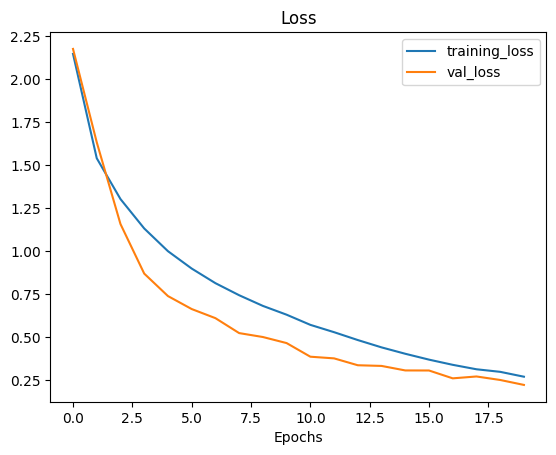

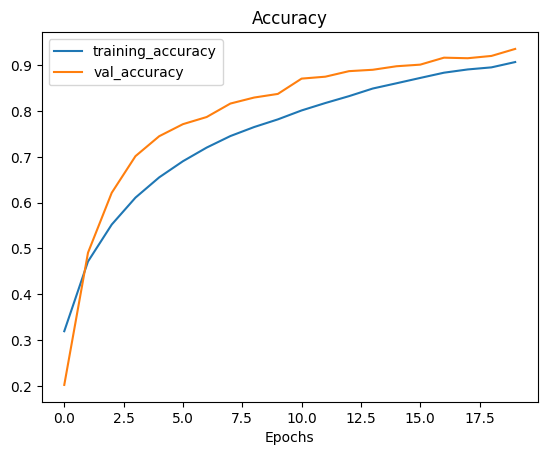

In [34]:
plot_loss_curves(history_mobilenet_phase2)

In [35]:
# Evaluate the model
test_loss, test_acc = model_mobilenet.evaluate(test_data)
print(f"MobileNetV2 Final Test Accuracy: {test_acc:.4f}")

313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.8019 - loss: 0.6876
MobileNetV2 Final Test Accuracy: 0.7965


#### Saving the MobileNetV2 model

In [36]:
model_mobilenet.save("model_mobilenet.h5")

#### Testing the MobileNetV2 model

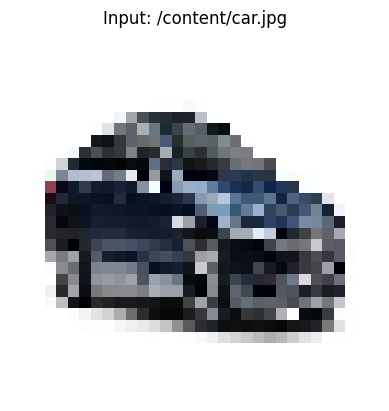

1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step
Predicted class: automobile
Confidence: 99.58%


In [37]:
predict_image(model_mobilenet,"/content/car.jpg")

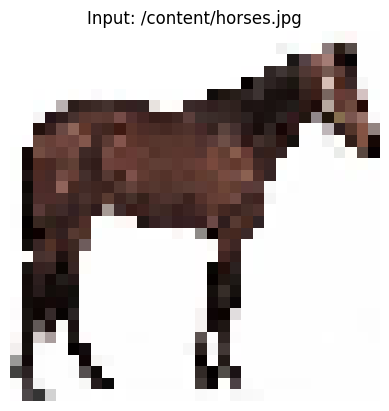

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
Predicted class: horse
Confidence: 93.86%


In [38]:
predict_image(model_mobilenet,"/content/horses.jpg")

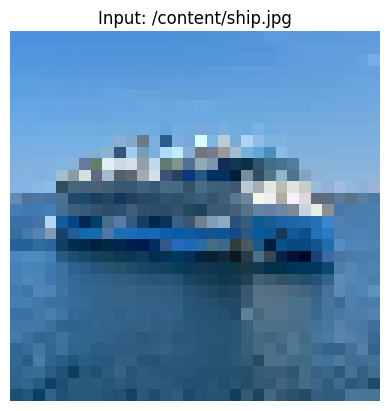

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
Predicted class: ship
Confidence: 98.79%


In [39]:
predict_image(model_mobilenet,"/content/ship.jpg")

### EfficientNetB0 Model Architecture

EfficientNetB0 serves as the baseline model in the EfficientNet family, a convolutional neural network optimized for high accuracy with minimal computational cost through compound scaling of depth, width, and resolution.

In [40]:
from tensorflow.keras.layers import GlobalMaxPooling2D

# CIFAR-10 classes
class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

print("Building EfficientNetB0 for CIFAR-10...")

# PHASE 1: Load pretrained EfficientNetB0 + Freeze
base_model = EfficientNetB0(
    input_shape=(32, 32, 3),        # CIFAR-10 size
    include_top=False,              # Remove ImageNet head
    weights='imagenet'             # Pretrained weights
)

base_model.trainable = False       # Freeze base model

x = base_model.output
x = GlobalMaxPooling2D()(x)
x = Dense(512, activation="relu")(x)
x = BatchNormalization()(x)
x = Dropout(0.5)(x)
predictions = Dense(10, activation="softmax")(x)

model_efficientnet = Model(inputs=base_model.input, outputs=predictions)

# Compile Phase 1 (high LR for head)
model_efficientnet.compile(
    loss="categorical_crossentropy",
    optimizer=Adam(learning_rate=0.001),  # Higher LR
    metrics=["accuracy"]
)

print("Phase 1: Training head only...")
history_efficientnet_phase1 = model_efficientnet.fit(
    train_data, epochs=10,
    steps_per_epoch=len(train_data),
    validation_data=val_data,
    validation_steps=len(val_data),
    callbacks=[early_stop, reduce_lr]
)

Building EfficientNetB0 for CIFAR-10...
16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Phase 1: Training head only...
Epoch 1/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 49s 20ms/step - accuracy: 0.1036 - loss: 2.5574 - val_accuracy: 0.1439 - val_loss: 2.3111 - learning_rate: 0.0010
Epoch 2/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 13s 9ms/step - accuracy: 0.1035 - loss: 2.3411 - val_accuracy: 0.1022 - val_loss: 2.3062 - learning_rate: 0.0010
Epoch 3/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 13s 9ms/step - accuracy: 0.1085 - loss: 2.3269 - val_accuracy: 0.1033 - val_loss: 2.3332 - learning_rate: 0.0010
Epoch 4/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 13s 9ms/step - accuracy: 0.1089 - loss: 2.3194 - val_accuracy: 0.1130 - val_loss: 2.3078 - learning_rate: 0.0010
Epoch 5/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 14s 9ms/step - accuracy: 0.1132 - loss: 2.3097 - val_accuracy: 0.1071 - val_loss: 2.2981 - learning_rate: 0.0010
Epoch 6/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 15s 11ms/step - accuracy: 0.1183 - loss: 2.3027 - val_accura

In [41]:
# PHASE 2: Fine-tune entire model
base_model.trainable = True  # Unfreeze all

# Lower LR for fine-tuning
model_efficientnet.compile(
    loss="categorical_crossentropy",
    optimizer=Adam(learning_rate=0.0001),  # 10x lower LR
    metrics=["accuracy"]
)

print("Phase 2: Fine-tuning entire EfficientNetB0...")
history_efficientnet_phase2 = model_efficientnet.fit(
    train_data, epochs=20,
    steps_per_epoch=len(train_data),
    validation_data=val_data,
    validation_steps=len(val_data),
    callbacks=[early_stop, reduce_lr]
)

Phase 2: Fine-tuning entire EfficientNetB0...
Epoch 1/20
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 109s 29ms/step - accuracy: 0.2175 - loss: 2.3378 - val_accuracy: 0.2791 - val_loss: 2.1634 - learning_rate: 1.0000e-04
Epoch 2/20
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 26s 19ms/step - accuracy: 0.4275 - loss: 1.6255 - val_accuracy: 0.3061 - val_loss: 2.1770 - learning_rate: 1.0000e-04
Epoch 3/20
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 26s 20ms/step - accuracy: 0.5216 - loss: 1.3625 - val_accuracy: 0.3580 - val_loss: 1.9229 - learning_rate: 1.0000e-04
Epoch 4/20
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 25s 19ms/step - accuracy: 0.5826 - loss: 1.1842 - val_accuracy: 0.3304 - val_loss: 2.1013 - learning_rate: 1.0000e-04
Epoch 5/20
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 41s 19ms/step - accuracy: 0.6368 - loss: 1.0460 - val_accuracy: 0.3493 - val_loss: 1.9026 - learning_rate: 1.0000e-04
Epoch 6/20
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 26s 19ms/step - accuracy: 0.6683 - loss: 0.9504 - val_accuracy: 0.3318 - val_loss: 2.3073 - learning_rate: 1.00

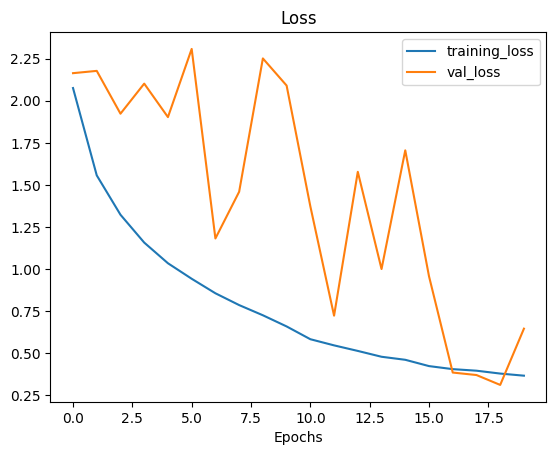

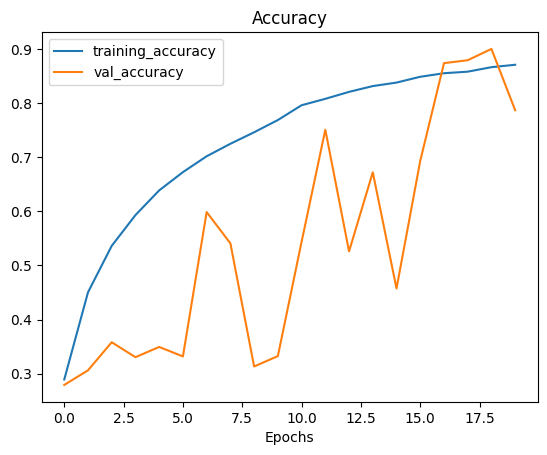

In [42]:
plot_loss_curves(history_efficientnet_phase2)

In [43]:
# Evaluate the model
test_loss, test_acc = model_efficientnet.evaluate(test_data)
print(f"EfficientNetB0 Final Test Accuracy: {test_acc:.4f}")

313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.7588 - loss: 0.7960
EfficientNetB0 Final Test Accuracy: 0.7495


#### Saving the EfficientNetB0 model

In [44]:
# Save the model
model_efficientnet.save("model_efficientnet.h5")

#### Testing  the EfficientNetB0 model

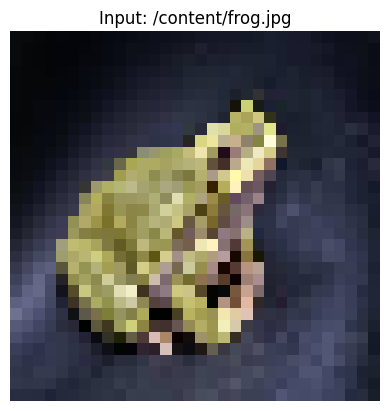

1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step
Predicted class: frog
Confidence: 84.98%


In [45]:
# Test the model
predict_image(model_efficientnet,"/content/frog.jpg")

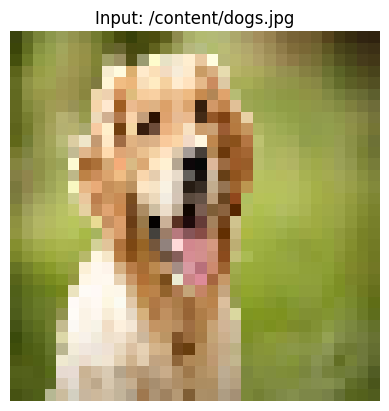

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
Predicted class: bird
Confidence: 89.47%


In [46]:
predict_image(model_efficientnet,"/content/dogs.jpg")

### VGG16 Model Architecture

VGG16 is a deep convolutional neural network architecture with 16 weighted layers, developed by the Visual Geometry Group at Oxford, renowned for its simplicity using small 3x3 filters stacked deeply for ImageNet classification.

In [47]:
print("Building VGG16 for CIFAR-10...")

# PHASE 1: Load pretrained VGG16 + Freeze
base_model = VGG16(
    input_shape=(32, 32, 3),        # CIFAR-10 size
    include_top=False,              # Remove ImageNet head
    weights='imagenet',             # Pretrained weights
    pooling=None
)

base_model.trainable = False      # Freeze base (Phase 1)

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(512, activation="relu")(x)
x = BatchNormalization()(x)
x = Dropout(0.5)(x)
predictions = Dense(10, activation="softmax")(x)

model_vgg16 = Model(inputs=base_model.input, outputs=predictions)

# Compile Phase 1
model_vgg16.compile(
    optimizer=Adam(learning_rate=0.001),
    loss="categorical_crossentropy",
    metrics=["accuracy"]
)

print("Phase 1: Training VGG16 head only...")
history_vgg16_phase1 = model_vgg16.fit(
    train_data, epochs=10,
    steps_per_epoch=len(train_data),
    validation_data=val_data,
    validation_steps=len(val_data),
    callbacks=[early_stop, reduce_lr]
)



Building VGG16 for CIFAR-10...
58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Phase 1: Training VGG16 head only...
Epoch 1/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 20s 12ms/step - accuracy: 0.4314 - loss: 1.7380 - val_accuracy: 0.5593 - val_loss: 1.2547 - learning_rate: 0.0010
Epoch 2/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 14s 10ms/step - accuracy: 0.5382 - loss: 1.3256 - val_accuracy: 0.5769 - val_loss: 1.1933 - learning_rate: 0.0010
Epoch 3/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 13s 9ms/step - accuracy: 0.5578 - loss: 1.2824 - val_accuracy: 0.5970 - val_loss: 1.1519 - learning_rate: 0.0010
Epoch 4/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 13s 9ms/step - accuracy: 0.5590 - loss: 1.2710 - val_accuracy: 0.5948 - val_loss: 1.1452 - learning_rate: 0.0010
Epoch 5/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 13s 9ms/step - accuracy: 0.5671 - loss: 1.2401 - val_accuracy: 0.5987 - val_loss: 1.1421 - learning_rate: 0.0010
Epoch 6/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 13s 9ms/step - accuracy: 0.5724 - loss: 1.2299 - val_accuracy:

In [48]:
# PHASE 2: Fine-tune entire model
base_model.trainable = True       # Unfreeze everything

model_vgg16.compile(
    optimizer=Adam(learning_rate=0.0001),  # Lower LR
    loss="categorical_crossentropy",
    metrics=["accuracy"]
)

print("Phase 2: Fine-tuning VGG16...")
history_vgg16_phase2 = model_vgg16.fit(
    train_data, epochs=20,
    steps_per_epoch=len(train_data),
    validation_data=val_data,
    validation_steps=len(val_data),
    callbacks=[early_stop, reduce_lr]
)

Phase 2: Fine-tuning VGG16...
Epoch 1/20
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 78s 52ms/step - accuracy: 0.6242 - loss: 1.0802 - val_accuracy: 0.7816 - val_loss: 0.6315 - learning_rate: 1.0000e-04
Epoch 2/20
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 64s 51ms/step - accuracy: 0.8166 - loss: 0.5395 - val_accuracy: 0.8363 - val_loss: 0.4793 - learning_rate: 1.0000e-04
Epoch 3/20
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 64s 51ms/step - accuracy: 0.8754 - loss: 0.3737 - val_accuracy: 0.8863 - val_loss: 0.3447 - learning_rate: 1.0000e-04
Epoch 4/20
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 65s 51ms/step - accuracy: 0.9137 - loss: 0.2576 - val_accuracy: 0.9205 - val_loss: 0.2408 - learning_rate: 1.0000e-04
Epoch 5/20
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 64s 51ms/step - accuracy: 0.9408 - loss: 0.1790 - val_accuracy: 0.9252 - val_loss: 0.2351 - learning_rate: 1.0000e-04
Epoch 6/20
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 65s 51ms/step - accuracy: 0.9602 - loss: 0.1205 - val_accuracy: 0.9430 - val_loss: 0.1951 - learning_rate: 1.0000e-04
Epoch 7/20

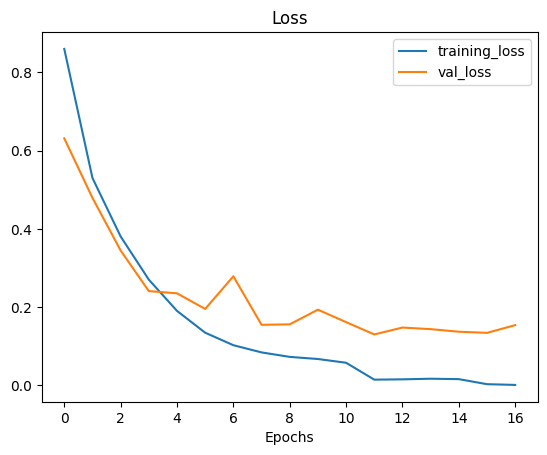

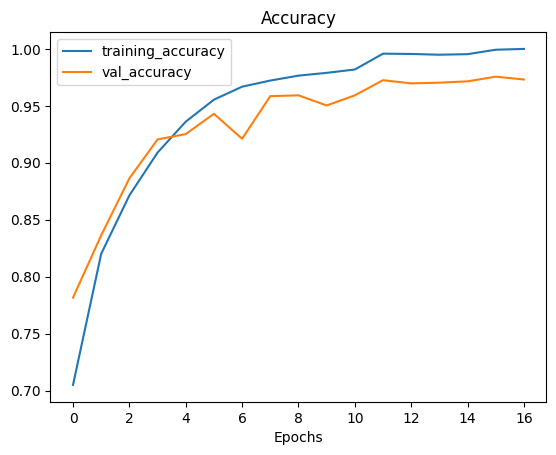

In [49]:
plot_loss_curves(history_vgg16_phase2)

In [50]:
# Evaluate the model
test_loss, test_acc = model_vgg16.evaluate(test_data)
print(f"VGG16 Final Test Accuracy: {test_acc:.4f}")


313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.8670 - loss: 0.6469
VGG16 Final Test Accuracy: 0.8635


#### Saving the VGG16 model

In [51]:
# Save
model_vgg16.save('model_vgg16.h5')

#### Testing the VGG16 model

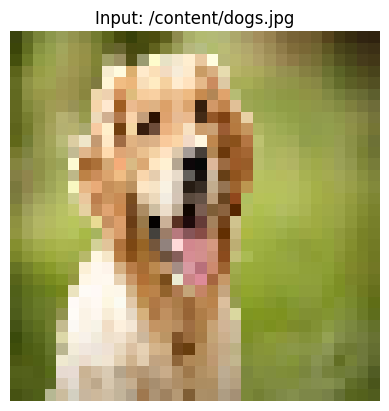

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
Predicted class: dog
Confidence: 99.91%


In [52]:
predict_image(model_vgg16,"/content/dogs.jpg")

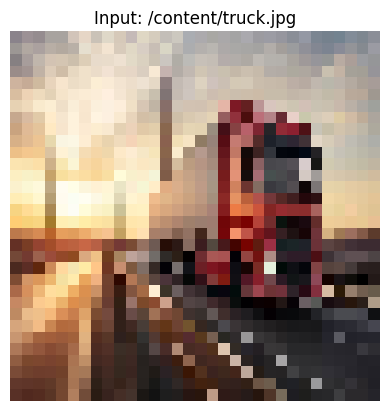

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
Predicted class: truck
Confidence: 99.98%


In [53]:
predict_image(model_vgg16,"/content/truck.jpg")

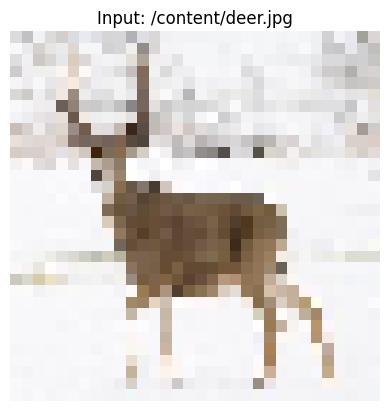

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
Predicted class: deer
Confidence: 99.99%


In [54]:
predict_image(model_vgg16,"/content/deer.jpg")

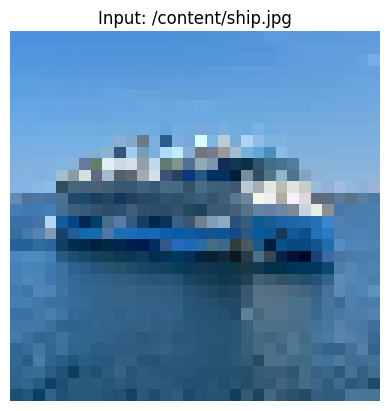

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
Predicted class: ship
Confidence: 100.00%


In [55]:
predict_image(model_vgg16,"/content/ship.jpg")

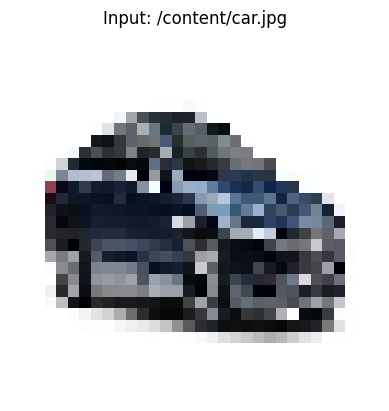

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
Predicted class: automobile
Confidence: 99.99%


In [56]:
predict_image(model_vgg16,"/content/car.jpg")

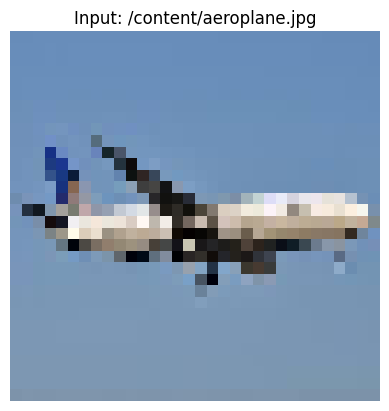

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
Predicted class: airplane
Confidence: 100.00%


In [57]:
predict_image(model_vgg16,"/content/aeroplane.jpg")

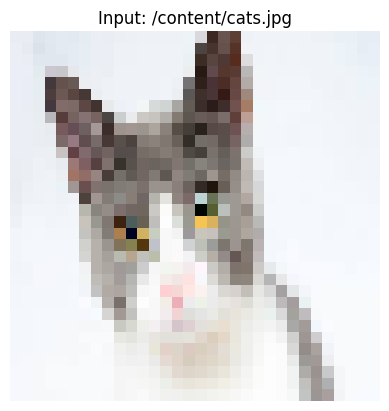

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
Predicted class: cat
Confidence: 99.97%


In [58]:
predict_image(model_vgg16,"/content/cats.jpg")

### ResNet50V2 Model Architecture

ResNet50V2 is a variant of the ResNet50 architecture, a 50-layer deep residual convolutional neural network that uses post-activation residual blocks for improved training stability and gradient flow in very deep networks.

In [59]:
print("Building ResNet50V2 for CIFAR-10...")

# PHASE 1: Load pretrained ResNet50V2 + Freeze
base_model = ResNet50V2(
    input_shape=(32, 32, 3),        # CIFAR-10 size
    include_top=False,              # Remove ImageNet head
    weights='imagenet',             # Pretrained weights
    pooling=None
)

base_model.trainable = False      # Freeze base (Phase 1)

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(512, activation="relu")(x)
x = BatchNormalization()(x)
x = Dropout(0.5)(x)
predictions = Dense(10, activation="softmax")(x)

model_resnet = Model(inputs=base_model.input, outputs=predictions)

# Compile Phase 1
model_resnet.compile(
    optimizer=Adam(learning_rate=0.001),
    loss="categorical_crossentropy",
    metrics=["accuracy"]
)

print("Phase 1: Training ResNet50V2 head only...")
history_resnet_phase1 = model_resnet.fit(
    train_data, epochs=10,
    steps_per_epoch=len(train_data),
    validation_data=val_data,
    validation_steps=len(val_data),
    callbacks=[early_stop, reduce_lr]
)


Building ResNet50V2 for CIFAR-10...
94668760/94668760 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step
Phase 1: Training ResNet50V2 head only...
Epoch 1/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 32s 15ms/step - accuracy: 0.2489 - loss: 2.4560 - val_accuracy: 0.3959 - val_loss: 1.7456 - learning_rate: 0.0010
Epoch 2/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 13s 9ms/step - accuracy: 0.3601 - loss: 1.8303 - val_accuracy: 0.4164 - val_loss: 1.6850 - learning_rate: 0.0010
Epoch 3/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 13s 9ms/step - accuracy: 0.3854 - loss: 1.7483 - val_accuracy: 0.4392 - val_loss: 1.6217 - learning_rate: 0.0010
Epoch 4/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 12s 9ms/step - accuracy: 0.4038 - loss: 1.7023 - val_accuracy: 0.4508 - val_loss: 1.5779 - learning_rate: 0.0010
Epoch 5/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 13s 9ms/step - accuracy: 0.4047 - loss: 1.6764 - val_accuracy: 0.4694 - val_loss: 1.5425 - learning_rate: 0.0010
Epoch 6/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 13s 9ms/step - accuracy: 0.4273 - loss: 1.6245 - val_

In [60]:
# PHASE 2: Fine-tune entire model
base_model.trainable = True       # Unfreeze everything

model_resnet.compile(
    optimizer=Adam(learning_rate=0.0001),  # Lower LR
    loss="categorical_crossentropy",
    metrics=["accuracy"]
)

print("Phase 2: Fine-tuning ResNet50V2...")
history_resnet_phase2 = model_resnet.fit(
    train_data, epochs=25,  # More epochs for deeper model
    steps_per_epoch=len(train_data),
    validation_data=val_data,
    validation_steps=len(val_data),
    callbacks=[early_stop, reduce_lr]
)


Phase 2: Fine-tuning ResNet50V2...
Epoch 1/25
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 95s 35ms/step - accuracy: 0.2622 - loss: 2.3596 - val_accuracy: 0.5213 - val_loss: 1.4762 - learning_rate: 1.0000e-04
Epoch 2/25
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 39s 30ms/step - accuracy: 0.4864 - loss: 1.4880 - val_accuracy: 0.6410 - val_loss: 1.0512 - learning_rate: 1.0000e-04
Epoch 3/25
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 39s 30ms/step - accuracy: 0.5897 - loss: 1.1921 - val_accuracy: 0.6987 - val_loss: 0.9101 - learning_rate: 1.0000e-04
Epoch 4/25
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 39s 30ms/step - accuracy: 0.6394 - loss: 1.0647 - val_accuracy: 0.7209 - val_loss: 0.8670 - learning_rate: 1.0000e-04
Epoch 5/25
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 39s 30ms/step - accuracy: 0.6948 - loss: 0.9084 - val_accuracy: 0.7315 - val_loss: 0.8257 - learning_rate: 1.0000e-04
Epoch 6/25
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 39s 30ms/step - accuracy: 0.7291 - loss: 0.8124 - val_accuracy: 0.7717 - val_loss: 1.1048 - learning_rate: 1.0000e-04
Epoch

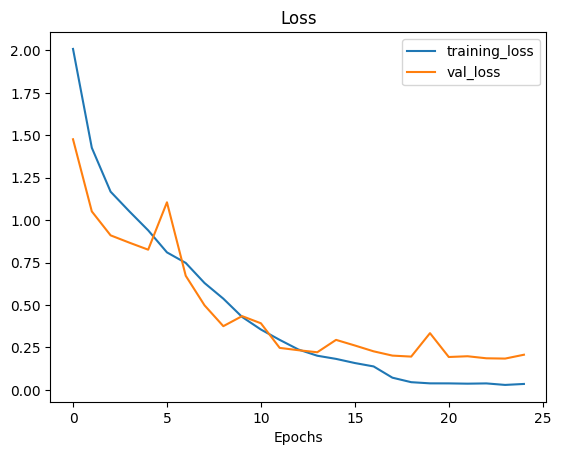

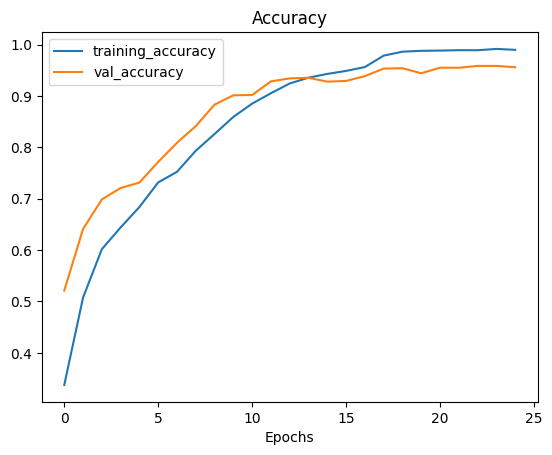

In [61]:
plot_loss_curves(history_resnet_phase2)

In [62]:
# Evaluate the model
test_loss, test_acc = model_resnet.evaluate(test_data)
print(f"ResNet50V2 Final Test Accuracy: {test_acc:.4f}")

313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.7904 - loss: 0.9365
ResNet50V2 Final Test Accuracy: 0.7866


#### Saving the ResNet50V2 model

In [63]:
model_resnet.save('model_resnet.h5')

#### Testing the ResNet50V2 model

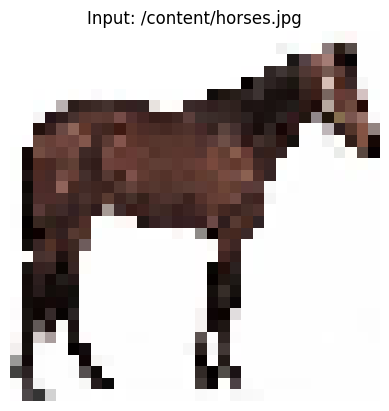

1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step
Predicted class: horse
Confidence: 99.99%


In [64]:
predict_image(model_resnet,"/content/horses.jpg")

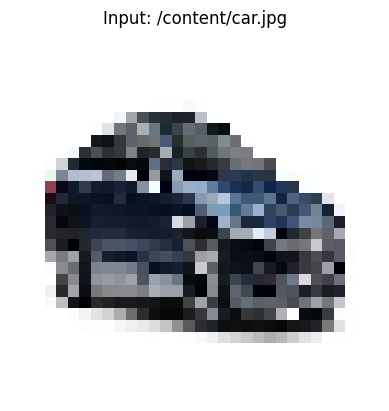

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
Predicted class: automobile
Confidence: 99.99%


In [65]:
predict_image(model_resnet,"/content/car.jpg")

## Models comparison

In [66]:
# Models
models = {
    "CNN Model": model_aug,
    "MobileNetV2": model_mobilenet,
    "EfficientNetB0": model_efficientnet,
    "VGG16": model_vgg16,
    "ResNet50V2": model_resnet
}

for model_name, model in models.items():
    print(f"Evaluating {model_name}...")
    test_loss, test_acc = model.evaluate(test_data)
    print(f"{model_name} Test Accuracy: {test_acc:.4f}")


Evaluating CNN Model...
313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.7883 - loss: 0.6124
CNN Model Test Accuracy: 0.7837
Evaluating MobileNetV2...
313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.8019 - loss: 0.6876
MobileNetV2 Test Accuracy: 0.7965
Evaluating EfficientNetB0...
313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.7588 - loss: 0.7960
EfficientNetB0 Test Accuracy: 0.7495
Evaluating VGG16...
313/313 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - accuracy: 0.8670 - loss: 0.6469
VGG16 Test Accuracy: 0.8635
Evaluating ResNet50V2...
313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.7904 - loss: 0.9365
ResNet50V2 Test Accuracy: 0.7866


## Model Performance Summary

In this project, we evaluated four pre-trained CNN architectures—MobileNetV2, EfficientNetB0, VGG16, and ResNet50V2—on the CIFAR-10 test set using transfer learning with TensorFlow/Keras. The final test accuracies were:

|     Model	     |   Test Accuracy  |
|----------------|------------------|
|   CNN Model    |      0.7837      |
|  MobileNetV2	 |      0.7965      |
| EfficientNetB0 |      0.7495      |
|     VGG16	     |      0.8635      |
|   ResNet50V2	 |      0.7866      |

VGG16 outperformed the others with 86.35% accuracy, followed closely by ResNet50V2 at 78.66% and MobileNetV2 which achieved a solid 79.65%, while EfficientNetB0 lagged at 74.95%.

## Key Insights and Conclusion

VGG16 demonstrated the highest generalization to CIFAR-10, likely due to its deeper feature extraction layers tailored for image classification tasks, despite higher computational demands. This aligns with its strong baseline performance on similar datasets. Lightweight models like MobileNetV2 offered a good balance of speed and accuracy, making them suitable for resource-constrained environments.

Overall, transfer learning proved effective for rapid prototyping, boosting accuracies beyond typical from-scratch CNNs on CIFAR-10 (often ~70-80%). However, EfficientNetB0 underperformed here, suggesting it may benefit from heavier fine-tuning or augmentation strategies.

## Future Scope

For image recognition projects, prioritize VGG16 for maximum accuracy or MobileNetV2 for efficiency. Future work could integrate data augmentation, learning rate scheduling, or ensemble methods to push VGG16 past 90%.